# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [278]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration

## I) Portfolio data

In [18]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [16]:
print('Rows and Columns in portfolio data', portfolio.shape)

Rows and Columns in portfolio data (10, 6)


In [20]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [21]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [114]:
portfolio.rename({'id': 'offer_id'}, axis=1, inplace=True)
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [151]:

def get_df_name(df):
    '''
    Extracts name from a dataframe
    Attributes:
        df: any dataframe
    Returns:
        name: name string of the dataframe
    '''
    name =[x for x in globals() if globals()[x] is df][0]
    return name

#Plotting bar chart 
def plot_bar(df, colname):
    '''
    Creates a bar plot of counts for a column in df
    Arrtibutes:
        df= dataframe
        colname= name of a column to plot
    Returns:
        None
    '''
    name_df= get_df_name(df)
    df_sub=pd.DataFrame(df[colname].value_counts())
    max_count=df[colname].value_counts().max()
    ax= sns.barplot(x=df_sub.index, y=df_sub[colname])
    ax.set_xlabel(colname)
    ax.set_ylabel('Total Count')
    ax.set_title(colname + ' counts in '+ name_df +' data')

    for p in ax.patches:
                 ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                     textcoords='offset points')


    _ = ax.set_ylim(0,max_count+int(max_count/3)) #To make space for the annotations

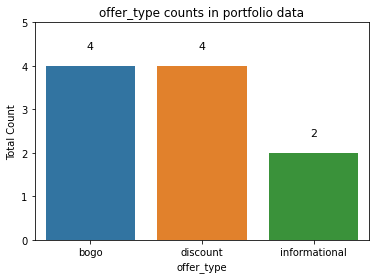

In [152]:
plot_bar(portfolio,'offer_type')

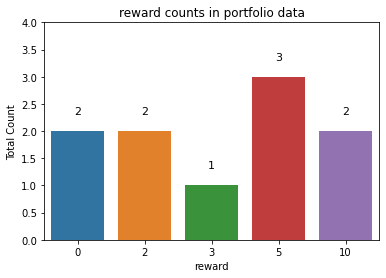

In [153]:
#portfolio.columns
plot_bar(portfolio,'reward')

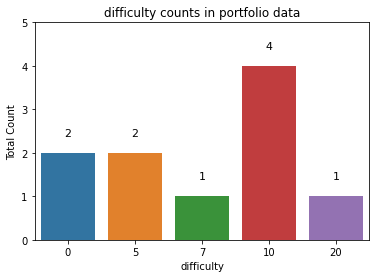

In [154]:
plot_bar(portfolio,'difficulty')

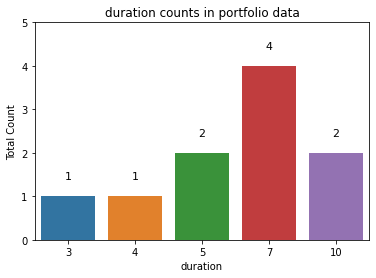

In [155]:
plot_bar(portfolio,'duration')

## II) Profile data

In [156]:
print(profile.head(10))
print('Shape of profile data set:', profile.shape)

  gender  age                       customer_id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN
5      M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0
6   None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925       NaN
7   None  118  68617ca6246f4fbc85e91a2a49552598          20171002       NaN
8      M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0
9   None  118  8974fc5686fe429db53ddde067b88302          20161122       NaN
Shape of profile data set: (17000, 5)


In [302]:
#Check null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

###  There are 2175 null values in gender and income columns. Checking for some connections...

In [304]:
profile_sub=profile[profile['gender'].isnull()]
profile_sub.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN
10,None,118,c4863c7985cf408faee930f111475da3,20170824,NaN
11,None,118,148adfcaa27d485b82f323aaaad036bd,20150919,NaN
17,None,118,744d603ef08c4f33af5a61c8c7628d1c,20170801,NaN
23,None,118,2b826eba31074a059d63b0ae8f50b7d5,20170907,NaN


### It looks like the gender and income are missing for age 118. We want to confirm this by checking unique age values.

In [305]:
profile_sub['age'].unique()

array([118])

### So, all the missing income and gender have age 118. 

In [306]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

## II (a) Explore the gender counts

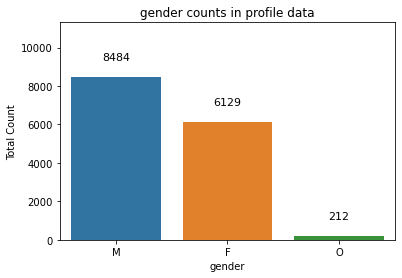

In [307]:
#Check the gender counts
plot_bar(profile,'gender')

## II (b) Explore the age 

In [308]:
profile['age'].value_counts().sort_values(ascending=False)

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [370]:
profile['age'].sort_values().unique()

array([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 118])

<AxesSubplot:xlabel='age'>

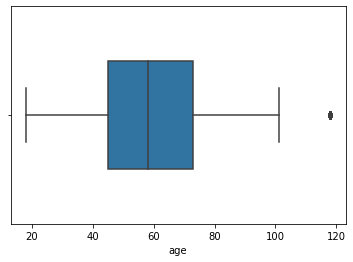

In [373]:
sns.boxplot(profile['age'], width=0.5)


### This shows the customers with age greateer than 80 don't drink much beverages. 

## Explore income, age and gender

In [310]:
ind_isna=profile['income'].isna()
df_new=profile[~ind_isna].groupby('gender')

<AxesSubplot:>

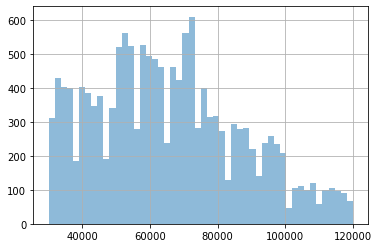

In [311]:
profile[~ind_isna]['income'].hist(bins=50, alpha=0.5)


Text(0.5, 1.0, 'Scatter plot: Income-age by gender ')

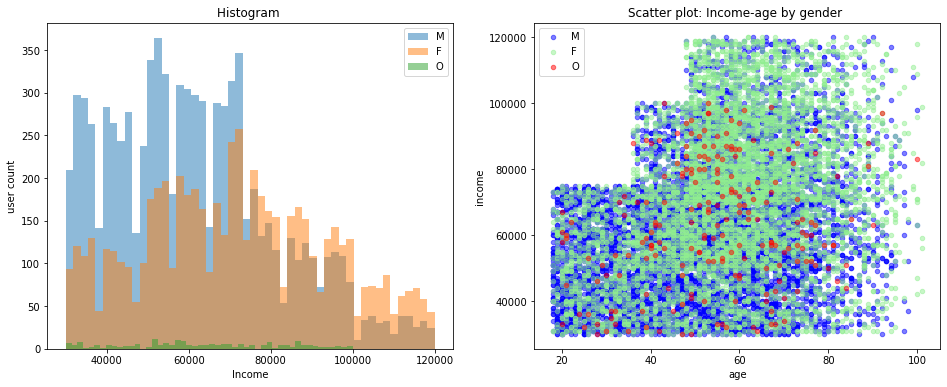

In [312]:
fig1, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axs = axs.flatten()

df_new.get_group('M')['income'].hist(bins=50, ax=axs[0], alpha=0.5, label='M')
df_new.get_group('F')['income'].hist(bins=50, ax=axs[0], alpha=0.5, label='F')
df_new.get_group('O')['income'].hist(bins=50, ax=axs[0], alpha=0.5, label='O')

axs[0].set_title('Histogram ')
axs[0].set_ylabel('user count')
#axs[0].set_xscale('linear')
axs[0].set_xlabel('Income')
axs[0].legend()
axs[0].grid(False)
#
df_new.get_group('M').plot.scatter(x='age', y='income', color='blue',ax=axs[1], alpha=0.5, label='M')
df_new.get_group('F').plot.scatter(x='age', y='income', color='lightgreen', ax=axs[1], alpha=0.5, label='F')
df_new.get_group('O').plot.scatter(x='age', y='income', color='red',ax=axs[1], alpha=0.5, label='O')
axs[1].set_title('Scatter plot: Income-age by gender ')

### Splitting income on the basis of gender shows the number of men with income less than 80,000 is considerably higher than the number of female. The scatter plot of income versus age for different gender group shows strong correlation between some ranges of age and income.

# III) Explore the transcript data

In [371]:
transcript.head(10)

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [372]:
print('The shape of transcript data:', transcript.shape)

The shape of transcript data: (306534, 4)


In [314]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [315]:
# Check the null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [316]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

## III (a) Explore event column

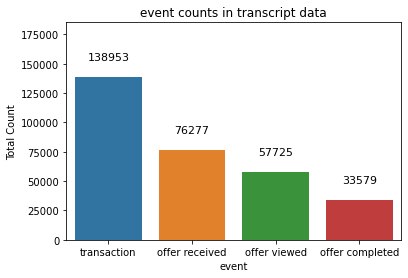

In [317]:
plot_bar(transcript,'event')

In [319]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


In [320]:
#Separating the value columns and merging them to the original transcript df
transcript_long = transcript.join(
    pd.DataFrame.from_records(transcript['value']))
#Removing the 'value' column
transcript_long.pop('value')

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [321]:
transcript_long

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN,NaN


### The 'value' column is split into four columns: 'offer id', 'amount', 'offer_id' and 'reward'.

In [296]:
# Unique 'event' values
transcript_long['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [295]:
# Analyzing data for offer recevied 
transcript_long.query('event=="offer received"').head()


,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [297]:
# Analyzing data for offer viewed 
transcript_long.query('event=="offer viewed"').head()

,person,event,time,offer id,amount,offer_id,reward
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN


### We can see offer id associated with each offer received and offer viewed .

In [298]:
#Analyzing data for transaction
transcript_long.query('event=="transaction"').head()

,person,event,time,offer id,amount,offer_id,reward
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,NaN,0.83,NaN,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,34.56,NaN,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,NaN,13.23,NaN,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,NaN,19.51,NaN,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,NaN,18.97,NaN,NaN


### We can see amount associated with each transaction.

In [291]:
transcript_long.query('event=="offer completed"').head()

,person,event,time,offer id,amount,offer_id,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


### We can see offer_id (not 'offer id') is associated with each offer completed.

In [299]:
#Analyzing random person
transcript_long.query('person=="9fa9ae8f57894cc9a3b8a9bbe0fc1b2f"').head()

,person,event,time,offer id,amount,offer_id,reward
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer viewed,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,34.56,NaN,NaN
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
27850,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,42,NaN,21.55,NaN,NaN


### All four distinct events can happen to a person at a same time (0).

In [300]:
#Combining above five cells.
display(pd.DataFrame().append([
    transcript_long.query('event=="offer received"').head(),
    transcript_long.query('event=="offer viewed"').head(),
    transcript_long.query('event=="transaction"').head(),
    transcript_long.query('event=="offer completed"').head(),
    transcript_long.query('person=="9fa9ae8f57894cc9a3b8a9bbe0fc1b2f"').head()]))

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN


In [359]:
transcript_long.groupby('person')['time'].count()

person
0009655768c64bdeb2e877511632db8f    20
00116118485d4dfda04fdbaba9a87b5c     7
0011e0d4e6b944f998e987f904e8c1e5    18
0020c2b971eb4e9188eac86d93036a77    19
0020ccbbb6d84e358d3414a3ff76cffd    23
                                    ..
fff3ba4757bd42088c044ca26d73817a    23
fff7576017104bcc8677a8d63322b5e1    18
fff8957ea8b240a6b5e634b6ee8eafcf    10
fffad4f4828548d1b5583907f2e9906b    23
ffff82501cea40309d5fdd7edcca4a07    33
Name: time, Length: 17000, dtype: int64

In [362]:
transcript_long[transcript_long['person']=='ffff82501cea40309d5fdd7edcca4a07']

,person,event,time,offer id,amount,offer_id,reward
1393,ffff82501cea40309d5fdd7edcca4a07,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
15836,ffff82501cea40309d5fdd7edcca4a07,offer viewed,6,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
32762,ffff82501cea40309d5fdd7edcca4a07,transaction,60,NaN,16.06,NaN,NaN
32763,ffff82501cea40309d5fdd7edcca4a07,offer completed,60,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
37060,ffff82501cea40309d5fdd7edcca4a07,transaction,78,NaN,7.18,NaN,NaN
45575,ffff82501cea40309d5fdd7edcca4a07,transaction,120,NaN,9.12,NaN,NaN
54574,ffff82501cea40309d5fdd7edcca4a07,offer received,168,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
69626,ffff82501cea40309d5fdd7edcca4a07,offer viewed,174,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
79667,ffff82501cea40309d5fdd7edcca4a07,transaction,198,NaN,22.88,NaN,NaN
79668,ffff82501cea40309d5fdd7edcca4a07,offer completed,198,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0
